# EDA and Statistical Analysis

## TODO - Questions

1. **Data Cleaning and Preprocessing**: Handle missing values, check for data inconsistencies, and prepare your data for further analysis.
2. **Descriptive Statistics**: Calculate measures of central tendency (mean, median, mode) and dispersion (range, variance, standard deviation) for metrics like points, assists, rebounds, etc.
3. **Probability Distributions**: Analyze the distribution of metrics across the NBA. Are they normally distributed or do they follow some other distribution? Are there noticeable skews or outliers?
4. **Correlation and Covariance Analysis**: Determine how different variables in your dataset are related. For example, is there a correlation between the number of assists a player has and the number of points they score?
5. **Hypothesis Testing**: Perform a statistical test to determine if there's a significant difference in teams' performance when playing home versus away games.
6. **Inferential Statistics**: Use hypothesis testing to make inferences about player performance. For example, are there statistically significant differences in player performance between different positions?
7. **Compare Player Per Game Stats vs Boxscore Stats**: Investigate how often players perform at, above, or below their average stats. This could help identify players that are particularly consistent or inconsistent in their performances.
8. **Compare Player Boxscores vs Game Outcome**: Investigate which player stats have the most impact on the game outcome.
9. **Regression Analysis**: Predict an outcome based on one or more predictors. For instance, you could use linear regression to predict the number of points scored by a player based on their other stats (like assists, rebounds, etc.) or use logistic regression to predict the outcome of a game (win/lose) based on team stats.
10. **Clustering of Players**: Implement a clustering analysis to group players based on their performance metrics. This can reveal interesting patterns and groupings in your data.
11. **Bayesian Statistics**: Update the probability of a hypothesis as more evidence or information becomes available. For example, you can use a Bayesian approach to update the probability of a team winning a game based on new player stats.
12. **Time Series Analysis**: If your data is sequential over time, you could consider running time series analysis, such as identifying trends or seasonality in player performance or game outcomes.
13. **Multivariate Analysis**: Look at the relationship between more than two variables. For instance, how do player performance, team performance, and game location interact to affect game outcomes?
14. **Automate EDA process**: With your EDA process in place, consider how you can automate as much of it as possible. This will make it easier to incorporate new data as you continue your analysis.


## Imports and Global Settings

In [64]:
import os
import json
import sys
import numpy as np
from dotenv import load_dotenv
import pandas as pd
from pandas.tseries.offsets import Day
from scipy.stats import ttest_ind, ks_2samp
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sqlalchemy import create_engine
from ydata_profiling import ProfileReport
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import matplotlib.gridspec as gridspec

here = os.getcwd()
sys.path.append(os.path.join(here, ".."))

from config import NBA_IMPORTANT_DATES, TEAM_MAP
from src.etl.main_etl import ETLPipeline
from src.utils.general_utils import (
    find_season_information,
    determine_season_type,
    add_season_timeframe_info,
)


load_dotenv()
RDS_ENDPOINT = os.getenv("RDS_ENDPOINT")
RDS_PASSWORD = os.getenv("RDS_PASSWORD")

# Pandas Settings
pd.set_option("display.max_columns", 1000)
pd.set_option("display.max_rows", 1000)
pd.options.display.max_info_columns = 1000
pd.options.display.precision = 5

# Graphing Settings
sns.set_theme()

## Data Loading

### Database Connection

In [65]:
username = "postgres"
password = RDS_PASSWORD
endpoint = RDS_ENDPOINT
database = "nba_betting"
port = "5432"

# Create the connection string
connection_string = (
    f"postgresql+psycopg2://{username}:{password}@{endpoint}:{port}/{database}"
)

### Loading Games

In [66]:
start_date = "2010-09-01"

features = [
    "game_id",
    "game_datetime",
    "home_team",
    "away_team",
    "open_line",
    "home_score",
    "away_score",
]
games_query = (
    f"SELECT {', '.join(features)} FROM games WHERE game_datetime >= '{start_date}';"
)

with create_engine(connection_string).connect() as connection:
    games = pd.read_sql_query(games_query, connection, parse_dates=["game_datetime"])

### Loading Features

In [67]:
start_date = "2010-09-01"
start_date_int = int(start_date.replace("-", ""))  # Convert date to YYYYMMDD format

features = ["game_id", "data"]

# Extracting the YYYYMMDD portion of the game_id and comparing it with start_date_int
features_query = f"SELECT {', '.join(features)} FROM all_features_json WHERE CAST(LEFT(game_id, 8) AS INTEGER) >= {start_date_int};"

with create_engine(connection_string).connect() as connection:
    all_features = pd.read_sql_query(features_query, connection)

# Normalize the JSON strings in the 'data' column
expanded_data = pd.json_normalize(all_features["data"])

# Drop the original 'data' column and concatenate the expanded data
all_features = pd.concat([all_features.drop(columns=["data"]), expanded_data], axis=1)

### Loading Other Tables

In [68]:
# start_date = "2021-09-01"
# # NBA Stats Team Stats - Traditional
# features = [
#     "team_name",
#     "to_date",
#     "season",
#     "season_type",
#     "games",
#     "w",
#     "l",
#     "w_pct",
#     "plus_minus",
# ]
# team_nbastats_traditional_query = f"SELECT {', '.join(features)} FROM team_nbastats_general_traditional WHERE to_date >= '{start_date}';"

# # 538 Games and Team Stats
# features = [
#     "date",
#     "season",
#     "season_type",
#     "team1",
#     "team2",
#     "elo1_pre",
#     "elo2_pre",
#     "elo_prob1",
#     "elo_prob2",
#     "elo1_post",
#     "elo2_post",
#     "raptor1_pre",
#     "raptor2_pre",
#     "raptor_prob1",
#     "raptor_prob2",
#     "score1",
#     "score2",
# ]
# team_538_query = f"SELECT {', '.join(features)} FROM team_fivethirtyeight_games WHERE date >= '{start_date}'"

# with create_engine(connection_string).connect() as connection:
#     team_nbastats_traditional = pd.read_sql(
#         team_nbastats_traditional_query, connection, parse_dates=["to_date"]
#     )
#     team_538 = pd.read_sql(team_538_query, connection, parse_dates=["date"])

## Working Tables - **Restart From Here**

In [69]:
# Games
games_df = games.copy()

# Features
all_features_df = all_features.copy()

In [70]:
# # Other Tables
# # NBA Stats Team Traditional
# nbastats_team_traditional_df = team_nbastats_traditional.copy()

# # 538 Games and Team Stats
# team_538_df = team_538.copy()

## Data Cleaning and Preprocessing 

In [71]:
def print_table_info(df):
    # Print a sample of the data
    print("\nSample:")
    print(df.sample(10, random_state=42, ignore_index=True))

    # Print the info()
    print("\nInfo:")
    print(df.info(verbose=True, show_counts=True))

In [72]:
for df in [games_df, all_features_df]:
    print_table_info(df)


Sample:
          game_id game_datetime home_team away_team  open_line  home_score  \
0  20151121DETWAS    2015-11-21       DET       WAS       -1.0        95.0   
1  20210501LACDEN    2021-05-01       LAC       DEN       -5.5       104.0   
2  20210514GSWNOP    2021-05-14       GSW       NOP       -1.0       125.0   
3  20180222GSWLAC    2018-02-22       GSW       LAC      -11.0       134.0   
4  20131227GSWPHX    2013-12-27       GSW       PHX       -6.5       115.0   
5  20230327UTAPHX    2023-03-27       UTA       PHX        4.5       103.0   
6  20140406HOUDEN    2014-04-06       HOU       DEN      -10.5       130.0   
7  20140413SACMIN    2014-04-13       SAC       MIN        2.0       106.0   
8  20221120PHXNYK    2022-11-20       PHX       NYK       -5.5       116.0   
9  20140220GSWHOU    2014-02-20       GSW       HOU        1.5       102.0   

   away_score  
0        97.0  
1       110.0  
2       122.0  
3       127.0  
4        86.0  
5       117.0  
6       125.0  
7   

          game_id     season  away_ATL  away_BKN  away_BOS  away_CHA  \
0  20150202PHXMEM  2014-2015         0         0         0         0   
1  20210414DETLAC  2020-2021         0         0         0         0   
2  20141128INDORL  2014-2015         0         0         0         0   
3  20150329MIADET  2014-2015         0         0         0         0   
4  20120117UTALAC  2011-2012         0         0         0         0   
5  20211213ATLHOU  2021-2022         0         0         0         0   
6  20141130BOSSAS  2014-2015         0         0         0         0   
7  20160220ATLMIL  2015-2016         0         0         0         0   
8  20220405CHIMIL  2021-2022         0         0         0         0   
9  20211219MINDAL  2021-2022         0         0         0         0   

   away_CHI  away_CLE  away_DAL  away_DEN  away_DET  away_GSW  away_HOU  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0      

### Standardize Team Names

In [73]:
# nbastats_team_traditional_df = ETLPipeline.standardize_team_names(
#     nbastats_team_traditional_df, ["team_name"], TEAM_MAP, print_details=True
# )
# team_538_df = ETLPipeline.standardize_team_names(
#     team_538_df, ["team1", "team2"], TEAM_MAP, print_details=True
# )

### Downcast Data Types

In [74]:
# nbastats_team_traditional_df = ETLPipeline.downcast_data_types(
#     nbastats_team_traditional_df, print_details=True
# )
# team_538_df = ETLPipeline.downcast_data_types(team_538_df, print_details=True)

### Duplicate Records

In [75]:
# nbastats_team_traditional_df = ETLPipeline.check_duplicates(
#     nbastats_team_traditional_df, ["team_name", "to_date", "games"], print_details=True
# )
# team_538_df = ETLPipeline.check_duplicates(
#     team_538_df, ["date", "team1", "team2"], print_details=True
# )

### Pandas Profiling

In [76]:
# games_profile_report = ProfileReport(games_df, title="Games Profiling Report")
# games_profile_report.to_notebook_iframe()

In [77]:
# all_features_profile_report = ProfileReport(
#     all_features_df, title="All Features Profiling Report"
# )
# all_features_profile_report.to_notebook_iframe()

In [78]:
# nbastats_team_traditional_profile_report = ProfileReport(
#     nbastats_team_traditional_df, title="NBAStats Team Traditional Profiling Report"
# )
# nbastats_team_traditional_profile_report.to_notebook_iframe()

In [79]:
# team_538_profile_report = ProfileReport(team_538_df, title="Team 538 Profiling Report")
# team_538_profile_report.to_notebook_iframe()

## Vegas Miss Analysis

In [80]:
games_vegas_analysis_df = games_df.copy()

### Add Season and Date Information
Season, Reg/Post Season, Day of Week, Month, Day of Month, Day of Year, Week of Year

In [81]:
games_vegas_analysis_df = add_season_timeframe_info(games_vegas_analysis_df)

### Optional: Restrict to Regular Season or Postseason Games Only

In [82]:
games_vegas_analysis_df = games_vegas_analysis_df[
    games_vegas_analysis_df["season_type"] == "reg"
]

### Add Targets - Vegas Miss and Vegas Absolute Miss

In [83]:
games_vegas_analysis_df["total_score"] = (
    games_vegas_analysis_df["home_score"] + games_vegas_analysis_df["away_score"]
)
games_vegas_analysis_df["actual_score_diff_hv"] = (
    games_vegas_analysis_df["home_score"] - games_vegas_analysis_df["away_score"]
)
games_vegas_analysis_df["vegas_score_diff_hv"] = -games_vegas_analysis_df["open_line"]
games_vegas_analysis_df["vegas_miss"] = (
    games_vegas_analysis_df["actual_score_diff_hv"]
    - games_vegas_analysis_df["vegas_score_diff_hv"]
)
games_vegas_analysis_df["vegas_miss_zscore"] = (
    games_vegas_analysis_df["vegas_miss"] - games_vegas_analysis_df["vegas_miss"].mean()
) / games_vegas_analysis_df["vegas_miss"].std()
games_vegas_analysis_df["vegas_miss_abs"] = games_vegas_analysis_df["vegas_miss"].abs()
games_vegas_analysis_df["vegas_miss_abs_zscore"] = (
    games_vegas_analysis_df["vegas_miss_abs"]
    - games_vegas_analysis_df["vegas_miss_abs"].mean()
) / games_vegas_analysis_df["vegas_miss_abs"].std()

# A negative vegas_miss means that vegas undervalued the home team and/or overvalued the away team
# A negative vegas_miss also means that the home team outperformed vegas' expectations

### Univariate Analysis for Vegas Miss and Vegas Absolute Miss

In [84]:
def compute_stats(series, print_stats=False, percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]):
    series = pd.Series(series)  # Make sure the input is a pandas Series
    stats = {
        "count": len(series),
        "max": series.max(),
        "min": series.min(),
        "range": series.max() - series.min(),
        "mean": series.mean(),
        "median": series.median(),
        "mode": series.mode()[0] if not series.mode().empty else None,
        "variance": series.var(),
        "std_dev": series.std(),
        "IQR": series.quantile(0.75) - series.quantile(0.25),
        "skewness": series.skew(),
        "kurtosis": series.kurt(),
    }

    # Add percentiles to stats
    for percentile in percentiles:
        key = f"{int(percentile*100)}th_pct"
        stats[key] = series.quantile(percentile)

    if print_stats:
        for key, value in stats.items():
            print(f"{key.capitalize()}: {value}")

    return stats

In [85]:
print("VEGAS MISS STATS")
vegas_miss_stats = compute_stats(games_vegas_analysis_df["vegas_miss"], print_stats=True)
print("\nVEGAS ABSOLUTE MISS STATS")
vegas_abs_miss_stats = compute_stats(
    games_vegas_analysis_df["vegas_miss_abs"], print_stats=True
)

VEGAS MISS STATS
Count: 15441
Max: 62.0
Min: -54.0
Range: 116.0
Mean: -0.15765084790324702
Median: 0.0
Mode: 1.5
Variance: 151.0215029541365
Std_dev: 12.289080639093248
Iqr: 15.5
Skewness: 0.045403535612042946
Kurtosis: 0.4611037061608174
10th_pct: -15.5
25th_pct: -8.0
50th_pct: 0.0
75th_pct: 7.5
90th_pct: 15.5

VEGAS ABSOLUTE MISS STATS
Count: 15441
Max: 62.0
Min: 0.0
Range: 62.0
Mean: 9.580616537399763
Median: 8.0
Mode: 1.5
Variance: 59.25211160302923
Std_dev: 7.697539321304519
Iqr: 10.5
Skewness: 1.208797356067183
Kurtosis: 1.7602751700824735
10th_pct: 1.5
25th_pct: 3.5
50th_pct: 8.0
75th_pct: 14.0
90th_pct: 20.0


In [86]:
def create_univarate_plots(df, target, title):
    # create 1x3 subplots
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))

    # displot with rug in first subplot
    sns.histplot(df[target], kde=True, ax=ax[0])
    sns.rugplot(df[target], ax=ax[0])
    ax[0].set_title("Density plot with Rug plot")

    # boxplot in second subplot
    sns.boxplot(x=df[target], ax=ax[1])
    ax[1].set_title("Box plot")

    # ECDF in third subplot
    sns.ecdfplot(df[target], ax=ax[2])
    ax[2].set_title("ECDF plot")

    # set title for the whole figure
    fig.suptitle(title, fontsize=20)

    # automatically adjust the subplot layout
    plt.tight_layout()

    # adjust the position of the suptitle to prevent it from overlapping with subplots' titles
    fig.subplots_adjust(top=0.88)

    # display the plot
    plt.show()

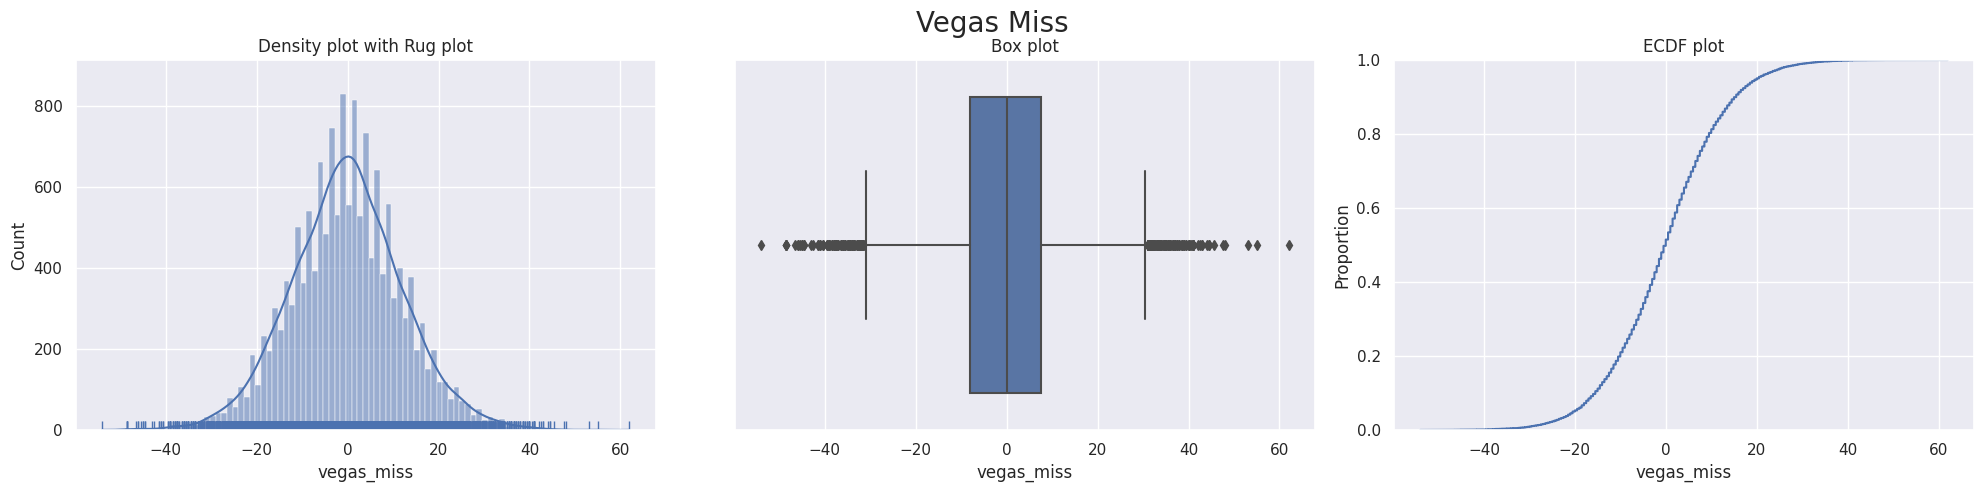

In [87]:
create_univarate_plots(games_vegas_analysis_df, "vegas_miss", "Vegas Miss")

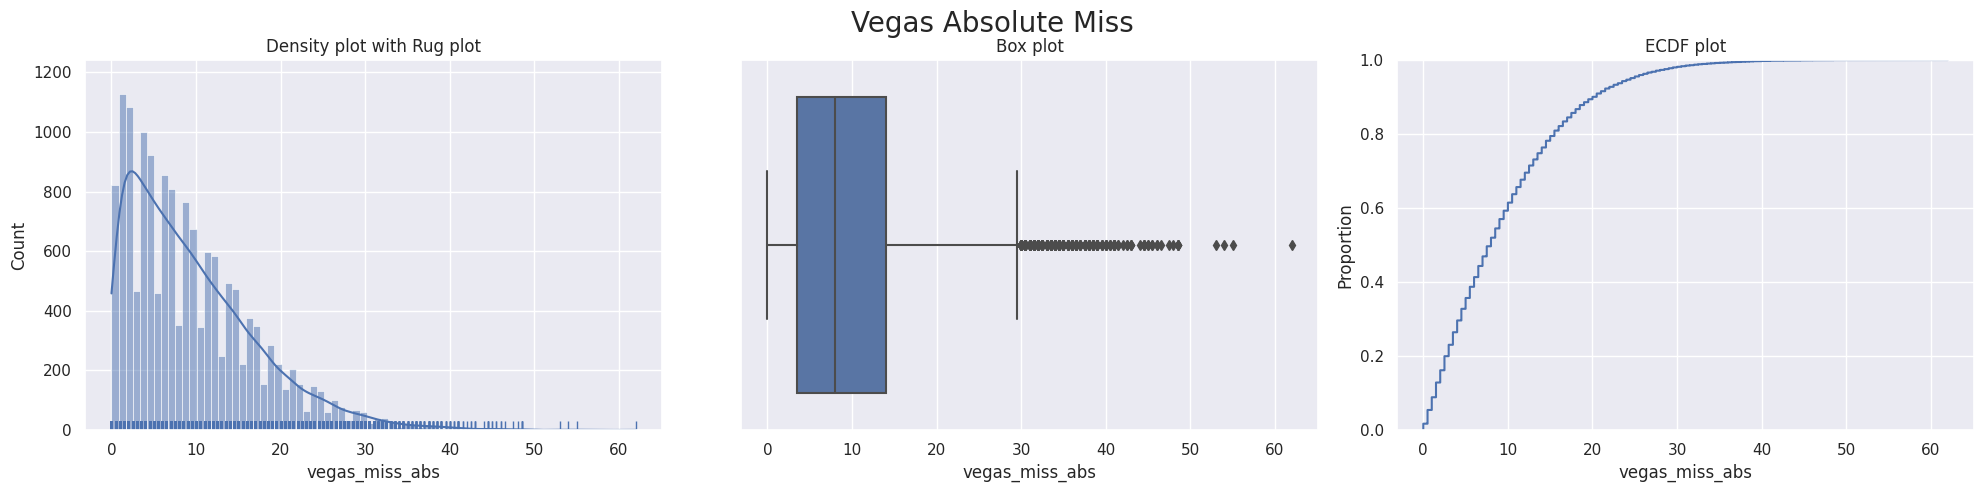

In [88]:
create_univarate_plots(games_vegas_analysis_df, "vegas_miss_abs", "Vegas Absolute Miss")

In [89]:
games_vegas_analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15441 entries, 0 to 16668
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   game_id                15441 non-null  object        
 1   game_datetime          15441 non-null  datetime64[ns]
 2   home_team              15441 non-null  object        
 3   away_team              15441 non-null  object        
 4   open_line              15214 non-null  float64       
 5   home_score             15340 non-null  float64       
 6   away_score             15340 non-null  float64       
 7   season                 15441 non-null  object        
 8   season_type            15441 non-null  object        
 9   day_of_week            15441 non-null  float64       
 10  month                  15441 non-null  float64       
 11  month_of_season        15441 non-null  float64       
 12  week_of_season         15441 non-null  float64       
 13  t

### Main Vegas Miss Graph

In [90]:
def vegas_miss_graph(vegas_miss_abs, season, save=False, image_name=None):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_title(
        " Vegas Average Point Spread Error Per Game",
        fontsize=24,
        pad=16,
        fontweight="bold",
    )
    ax.set_xlabel("Season", fontsize=18, labelpad=8, fontweight="bold")
    ax.set_ylabel("Spread Error (Points)", fontsize=18, labelpad=8, fontweight="bold")

    # Create a new DataFrame from the two Series
    df = pd.DataFrame({"vegas_miss_abs": vegas_miss_abs, "season": season})

    # Sort the DataFrame by the 'season' column
    df = df.sort_values("season")

    # Calculate overall mean value
    overall_avg = df["vegas_miss_abs"].mean()

    sns.lineplot(
        x="season", y="vegas_miss_abs", data=df, ax=ax, linewidth=4, errorbar=None
    )

    ax.axhline(overall_avg, color="#C9082A", linestyle="--", linewidth=2)
    ax.text(
        x=df["season"].min(),
        y=overall_avg + 0.05,
        s=f"Overall Average: {overall_avg:.2f}",
        color="#C9082A",
        fontsize=16,
        fontweight="bold",
    )

    # Get the existing x-ticks and labels
    existing_ticks = ax.get_xticks()
    existing_labels = ax.get_xticklabels()

    # Extract the start year from each label and set new x-tick labels
    new_labels = [label.get_text().split("-")[0] for label in existing_labels]
    ax.set_xticklabels(new_labels)

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    # plt.legend(fontsize=16)

    if save:
        plt.savefig(f"{image_name}.png", dpi=300, bbox_inches="tight")

/tmp/ipykernel_58194/3254670767.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)


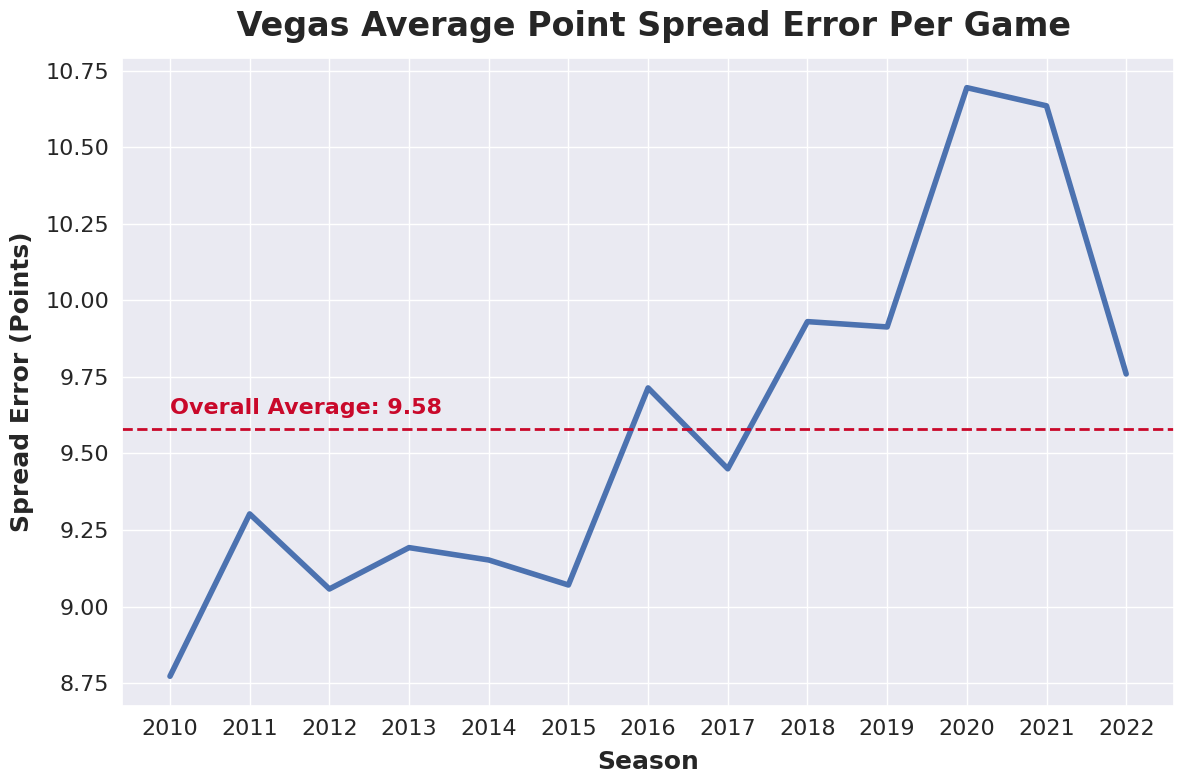

In [91]:
vegas_miss_graph(
    games_vegas_analysis_df["vegas_miss_abs"],
    games_vegas_analysis_df["season"],
    save=False,
    image_name="vegas_miss_abs",
)

### Secondary Vegas Miss Graphs

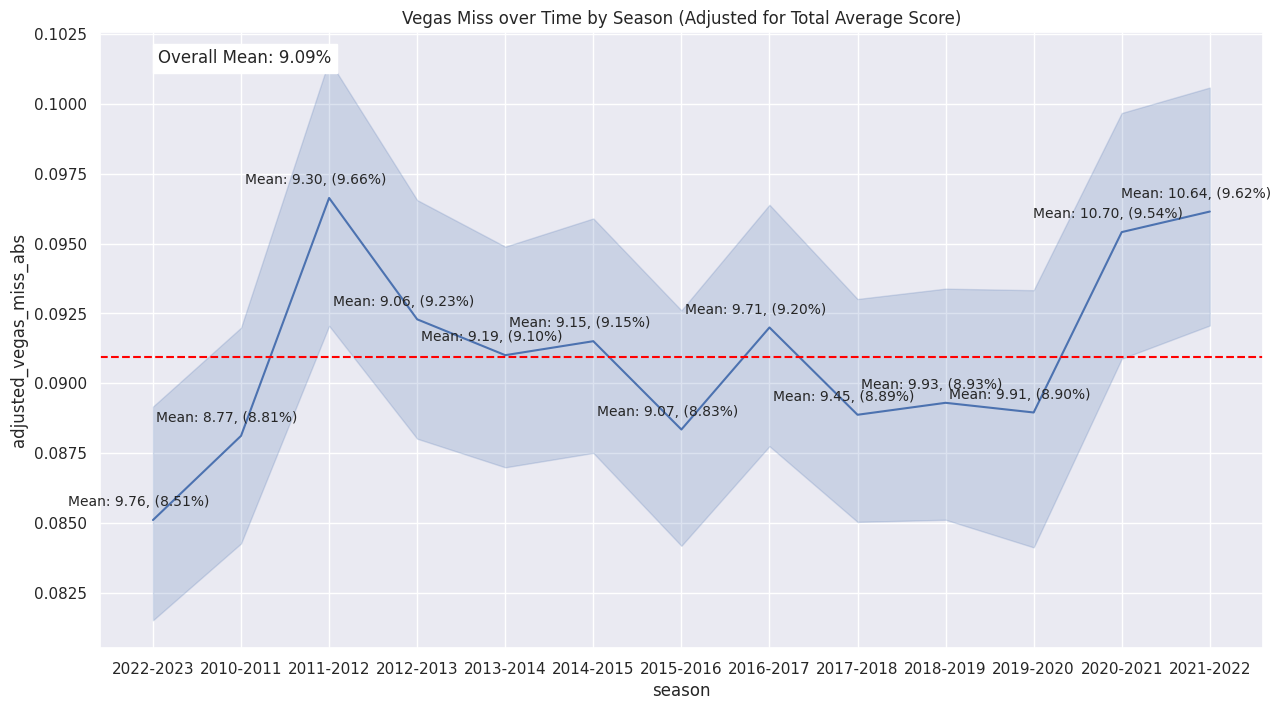

In [92]:
# Calculate the total average score for each season
games_vegas_analysis_df["avg_score"] = (
    games_vegas_analysis_df["home_score"] + games_vegas_analysis_df["away_score"]
) / 2
avg_score_by_season = games_vegas_analysis_df.groupby("season")["avg_score"].mean()

# Adjust the "vegas_miss_abs" values by the total average score
games_vegas_analysis_df["adjusted_vegas_miss_abs"] = games_vegas_analysis_df.apply(
    lambda row: row["vegas_miss_abs"] / avg_score_by_season[row["season"]], axis=1
)

# Calculate overall average
overall_avg = games_vegas_analysis_df["adjusted_vegas_miss_abs"].mean()

# Create a line plot
plt.figure(figsize=(15, 8))
sns.lineplot(data=games_vegas_analysis_df, x="season", y="adjusted_vegas_miss_abs")

# Add horizontal line showing overall average
plt.axhline(overall_avg, color="red", linestyle="--")

# Annotate the overall mean
overall_mean_text = f"Overall Mean: {overall_avg*100:.2f}%"
plt.annotate(
    overall_mean_text,
    xy=(0.05, 0.95),
    xycoords="axes fraction",
    backgroundcolor="white",
    fontsize=12,
)

# Annotating the mean for each week of the season
for season in games_vegas_analysis_df["season"].unique():
    season_mean = games_vegas_analysis_df.loc[
        games_vegas_analysis_df["season"] == season, "adjusted_vegas_miss_abs"
    ].mean()
    season_abs_mean = games_vegas_analysis_df.loc[
        games_vegas_analysis_df["season"] == season, "vegas_miss_abs"
    ].mean()
    plt.annotate(
        f"Mean: {season_abs_mean:.2f}, ({season_mean*100:.2f}%)",
        (season, season_mean),
        textcoords="offset points",
        xytext=(-10, 10),
        ha="center",
        fontsize=10,
    )

# Set title
plt.title("Vegas Miss over Time by Season (Adjusted for Total Average Score)")

plt.show()

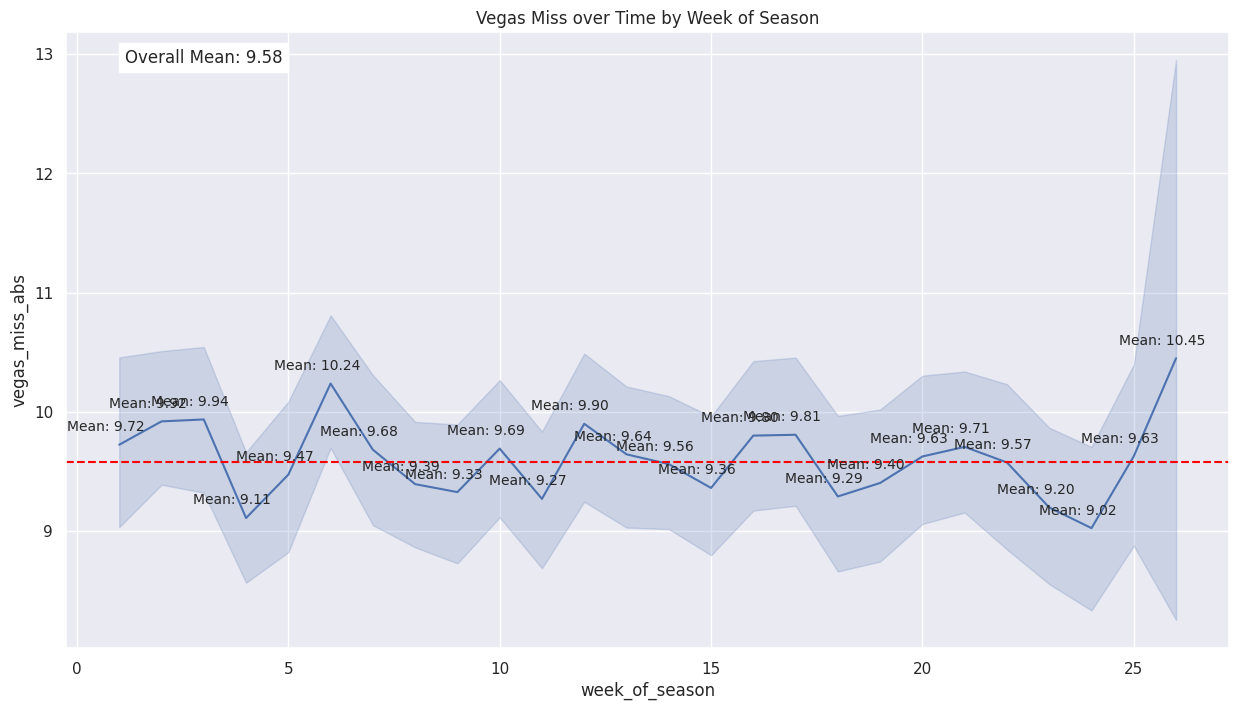

In [93]:
# Calculate overall average
overall_avg = games_vegas_analysis_df["vegas_miss_abs"].mean()

# Create a line plot
plt.figure(figsize=(15, 8))
sns.lineplot(data=games_vegas_analysis_df, x="week_of_season", y="vegas_miss_abs")

# Add horizontal line showing overall average
plt.axhline(overall_avg, color="red", linestyle="--")

# Annotate the overall mean
overall_mean_text = f"Overall Mean: {overall_avg:.2f}"
plt.annotate(
    overall_mean_text,
    xy=(0.05, 0.95),
    xycoords="axes fraction",
    backgroundcolor="white",
    fontsize=12,
)

# Annotating the mean for each week of the season
for week in games_vegas_analysis_df["week_of_season"].unique():
    week_mean = games_vegas_analysis_df.loc[
        games_vegas_analysis_df["week_of_season"] == week, "vegas_miss_abs"
    ].mean()
    plt.annotate(
        f"Mean: {week_mean:.2f}",
        (week, week_mean),
        textcoords="offset points",
        xytext=(-10, 10),
        ha="center",
        fontsize=10,
    )

# Set title
plt.title("Vegas Miss over Time by Week of Season")

plt.show()

### Multivariate Analysis for Vegas Miss and Vegas Absolute Miss

In [94]:
def compare_stats(df, series_name, situations):
    overall_stats = compute_stats(df[series_name])

    result = pd.DataFrame()
    for situation, condition in situations.items():
        subset = df.loc[condition]
        subset_stats = compute_stats(subset[series_name])
        for key, value in subset_stats.items():
            result.at[situation, key] = value
        t_stat, p_value_ttest = ttest_ind(
            df[series_name], subset[series_name], equal_var=False, nan_policy="omit"
        )
        ks_stat, p_value_ks = ks_2samp(
            df[series_name], subset[series_name], alternative="two-sided"
        )
        result.at[situation, "p_value_ttest"] = p_value_ttest
        result.at[situation, "p_value_ks"] = p_value_ks
        result.at[situation, "significant_difference_ttest"] = (
            "Yes" if p_value_ttest < 0.05 else "No"
        )
        result.at[situation, "significant_difference_ks"] = (
            "Yes" if p_value_ks < 0.05 else "No"
        )
        result.at[situation, "difference_in_mean"] = (
            subset[series_name].mean() - df[series_name].mean()
        )

    return result

In [95]:
situations = {
    "Home Team is Favored": games_vegas_analysis_df["vegas_score_diff_hv"] > 0,
    "Away Team is Favored": games_vegas_analysis_df["vegas_score_diff_hv"] < 0,
    "Home team wins ATS": games_vegas_analysis_df["actual_score_diff_hv"]
    > games_vegas_analysis_df["vegas_score_diff_hv"],
    "Away team wins ATS": games_vegas_analysis_df["actual_score_diff_hv"]
    < games_vegas_analysis_df["vegas_score_diff_hv"],
    "Favorite wins ATS": (games_vegas_analysis_df["vegas_score_diff_hv"] > 0)
    & (
        games_vegas_analysis_df["actual_score_diff_hv"]
        > games_vegas_analysis_df["vegas_score_diff_hv"]
    )
    | (games_vegas_analysis_df["vegas_score_diff_hv"] < 0)
    & (
        games_vegas_analysis_df["actual_score_diff_hv"]
        < games_vegas_analysis_df["vegas_score_diff_hv"]
    ),
    "Underdog wins ATS": (games_vegas_analysis_df["vegas_score_diff_hv"] > 0)
    & (
        games_vegas_analysis_df["actual_score_diff_hv"]
        < games_vegas_analysis_df["vegas_score_diff_hv"]
    )
    | (games_vegas_analysis_df["vegas_score_diff_hv"] < 0)
    & (
        games_vegas_analysis_df["actual_score_diff_hv"]
        > games_vegas_analysis_df["vegas_score_diff_hv"]
    ),
}

for i in range(1, int(max(games_vegas_analysis_df["month_of_season"])) + 1):
    situations[f"Month {i} of season"] = games_vegas_analysis_df["month_of_season"] == i

spread_conditions = [
    (games_vegas_analysis_df["vegas_score_diff_hv"].abs() <= 3, "Within 3 of even"),
    (
        (games_vegas_analysis_df["vegas_score_diff_hv"].abs() > 3)
        & (games_vegas_analysis_df["vegas_score_diff_hv"].abs() <= 5),
        "3-5 of even",
    ),
    (
        (games_vegas_analysis_df["vegas_score_diff_hv"].abs() > 5)
        & (games_vegas_analysis_df["vegas_score_diff_hv"].abs() <= 10),
        "5-10 of even",
    ),
    (games_vegas_analysis_df["vegas_score_diff_hv"].abs() > 10, ">10 from even"),
]

for condition, label in spread_conditions:
    situations[label] = condition

result = compare_stats(games_vegas_analysis_df, "vegas_miss_abs", situations)

In [96]:
result

,count,max,min,range,mean,median,mode,variance,std_dev,IQR,skewness,kurtosis,10th_pct,25th_pct,50th_pct,75th_pct,90th_pct,p_value_ttest,p_value_ks,significant_difference_ttest,significant_difference_ks,difference_in_mean
Home Team is Favored,9884.0,62.0,0.0,62.0,9.51513,7.50,1.5,59.23763,7.69660,10.0,1.22169,1.81616,1.5,3.5,7.50,13.5,20.0,5.10151e-01,9.46596e-02,No,No,-0.06549
Away Team is Favored,5329.0,55.0,0.0,55.0,9.70351,8.00,2.5,59.26737,7.69853,10.5,1.18576,1.66283,1.5,3.5,8.00,14.0,20.5,3.15949e-01,3.07629e-01,No,No,0.12289
Home team wins ATS,7384.0,62.0,0.5,61.5,9.70754,8.00,1.5,59.95702,7.74319,10.5,1.25128,1.88345,1.5,3.5,8.00,14.0,20.5,2.46891e-01,1.18957e-01,No,No,0.12693
Away team wins ATS,7571.0,54.0,0.5,53.5,9.78457,8.00,1.5,57.40193,7.57641,10.0,1.18242,1.69142,1.5,4.0,8.00,14.0,20.5,5.69476e-02,7.61678e-02,No,No,0.20396
Favorite wins ATS,7470.0,62.0,0.5,61.5,9.28989,7.50,2.5,57.93185,7.61130,10.0,1.31411,2.06341,1.5,3.5,7.50,13.5,20.0,7.07805e-03,7.58472e-07,Yes,Yes,-0.29072
Underdog wins ATS,7484.0,55.0,0.5,54.5,10.20337,9.00,1.5,58.97968,7.67982,10.5,1.13293,1.58796,1.5,4.0,9.00,14.5,20.5,9.71553e-09,1.82020e-07,Yes,Yes,0.62275
Month 1 of season,803.0,54.0,0.0,54.0,10.08172,8.00,2.0,67.38668,8.20894,11.0,1.21436,1.73557,1.5,3.5,8.00,14.5,21.7,9.63575e-02,5.83655e-02,No,No,0.50111
Month 2 of season,2972.0,55.0,0.0,55.0,9.64650,8.00,0.5,58.11962,7.62362,10.5,1.13262,1.47920,1.5,3.5,8.00,14.0,20.0,6.70971e-01,3.36900e-01,No,No,0.06588
Month 3 of season,2887.0,62.0,0.0,62.0,9.50894,8.00,1.5,58.52333,7.65005,10.0,1.24115,2.14152,1.5,3.5,8.00,13.5,20.0,6.46462e-01,6.77209e-01,No,No,-0.07168
Month 4 of season,2949.0,48.5,0.0,48.5,9.60642,8.00,1.5,58.60457,7.65536,10.5,1.18576,1.59509,1.5,3.5,8.00,14.0,20.0,8.67762e-01,9.99895e-01,No,No,0.02580


In [97]:
# Compute pairwise correlation of columns
correlation_df = games_vegas_analysis_df.corr(numeric_only=True)

# Select the rows corresponding to the target columns
correlation_df = correlation_df.loc[["vegas_miss", "vegas_miss_abs"]]

In [98]:
correlation_df

,open_line,home_score,away_score,day_of_week,month,month_of_season,week_of_season,total_score,actual_score_diff_hv,vegas_score_diff_hv,vegas_miss,vegas_miss_zscore,vegas_miss_abs,vegas_miss_abs_zscore,avg_score,adjusted_vegas_miss_abs
vegas_miss,0.01739,0.45344,-0.45763,-0.00035,-0.00626,0.00086,0.00178,-0.00542,0.88119,-0.01739,1.00000,1.00000,0.00147,0.00147,-0.00542,0.00124
vegas_miss_abs,0.02173,-0.00053,0.00870,0.00475,0.00007,-0.01391,-0.01103,0.00480,-0.00896,-0.02173,0.00147,0.00147,1.00000,1.00000,0.00480,0.99609


In [99]:
# games_vegas_analysis_df_report = ProfileReport(
#     games_vegas_analysis_df, title="Game/Bet Profiling Report"
# )
# games_vegas_analysis_df_report.to_notebook_iframe()

## Target Feature Correlations

In [100]:
target_feature_df = all_features_df.copy()

In [101]:
target_feature_df["open_line_hv"] = -target_feature_df["open_line"]

In [102]:
target_feature_df["actual_score_diff_hv"] = (
    target_feature_df["home_score"] - target_feature_df["away_score"]
)

In [103]:
target_feature_df["REG_TARGET"] = target_feature_df["actual_score_diff_hv"]

In [104]:
target_feature_df["CLS_TARGET"] = (
    target_feature_df["actual_score_diff_hv"] > target_feature_df["open_line_hv"]
)  # bet_on_home boolean

In [105]:
target_feature_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16568 entries, 0 to 16567
Data columns (total 779 columns):
 #    Column                                        Non-Null Count  Dtype  
---   ------                                        --------------  -----  
 0    game_id                                       16568 non-null  object 
 1    season                                        16532 non-null  object 
 2    away_ATL                                      16568 non-null  int64  
 3    away_BKN                                      16568 non-null  int64  
 4    away_BOS                                      16568 non-null  int64  
 5    away_CHA                                      16568 non-null  int64  
 6    away_CHI                                      16568 non-null  int64  
 7    away_CLE                                      16568 non-null  int64  
 8    away_DAL                                      16568 non-null  int64  
 9    away_DEN                                      16

In [106]:
# Prep Df

# Drop columns that are not needed
drop_columns = [
    "game_id",
    "home_score",
    "away_score",
    "season",
    "season_type",
    "home_team",
    "away_team",
    "game_datetime",
    "open_line_hv",
    "actual_score_diff_hv",
    "raptor1_pre",
    "raptor2_pre",
    "raptor_prob1",
    "raptor_prob2",
    "carm_elo1_pre",
    "carm_elo2_pre",
    "carm_elo_prob1",
    "carm_elo_prob2",
    "home_team_last_5",
    "away_team_last_5",
]

target_feature_df = target_feature_df.drop(columns=drop_columns)

In [107]:
target_feature_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16568 entries, 0 to 16567
Data columns (total 759 columns):
 #    Column                                        Non-Null Count  Dtype  
---   ------                                        --------------  -----  
 0    away_ATL                                      16568 non-null  int64  
 1    away_BKN                                      16568 non-null  int64  
 2    away_BOS                                      16568 non-null  int64  
 3    away_CHA                                      16568 non-null  int64  
 4    away_CHI                                      16568 non-null  int64  
 5    away_CLE                                      16568 non-null  int64  
 6    away_DAL                                      16568 non-null  int64  
 7    away_DEN                                      16568 non-null  int64  
 8    away_DET                                      16568 non-null  int64  
 9    away_GSW                                      16

In [108]:
# Drop NA rows
target_feature_df.dropna(inplace=True)

In [109]:
target_feature_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15102 entries, 0 to 16558
Data columns (total 759 columns):
 #    Column                                        Non-Null Count  Dtype  
---   ------                                        --------------  -----  
 0    away_ATL                                      15102 non-null  int64  
 1    away_BKN                                      15102 non-null  int64  
 2    away_BOS                                      15102 non-null  int64  
 3    away_CHA                                      15102 non-null  int64  
 4    away_CHI                                      15102 non-null  int64  
 5    away_CLE                                      15102 non-null  int64  
 6    away_DAL                                      15102 non-null  int64  
 7    away_DEN                                      15102 non-null  int64  
 8    away_DET                                      15102 non-null  int64  
 9    away_GSW                                      15

In [110]:
features = [
    col for col in target_feature_df.columns if col not in ["CLS_TARGET", "REG_TARGET"]
]

# Point-biserial correlation for classification
cls_correlations = (
    target_feature_df[features].corrwith(target_feature_df["CLS_TARGET"]).abs()
)

# Pearson correlation for regression
reg_correlations = (
    target_feature_df[features].corrwith(target_feature_df["REG_TARGET"]).abs()
)

# Mutual Information
mi_classif = mutual_info_classif(
    target_feature_df[features], target_feature_df["CLS_TARGET"]
)
mi_reg = mutual_info_regression(
    target_feature_df[features], target_feature_df["REG_TARGET"]
)

# Feature importance using RandomForest
rf_classif = RandomForestClassifier(n_estimators=50, random_state=1)
rf_classif.fit(target_feature_df[features], target_feature_df["CLS_TARGET"])
classif_importance = rf_classif.feature_importances_

rf_reg = RandomForestRegressor(n_estimators=50, random_state=1)
rf_reg.fit(target_feature_df[features], target_feature_df["REG_TARGET"])
reg_importance = rf_reg.feature_importances_

# Combine results into a DataFrame
feature_selection_df = pd.DataFrame(
    {
        "Feature": features,
        "PB Corr CLS": cls_correlations.values,
        "Pearson Corr REG": reg_correlations.values,
        "MI CLS": mi_classif,
        "MI REG": mi_reg,
        "RF FI CLS": classif_importance,
        "RF FI REG": reg_importance,
    }
)

# Round to 2 decimals before ranking
feature_selection_df["PB Corr CLS"] = feature_selection_df["PB Corr CLS"].round(2)
feature_selection_df["Pearson Corr REG"] = feature_selection_df[
    "Pearson Corr REG"
].round(2)
feature_selection_df["MI CLS"] = feature_selection_df["MI CLS"].round(2)
feature_selection_df["MI REG"] = feature_selection_df["MI REG"].round(2)
feature_selection_df["RF FI CLS"] = feature_selection_df["RF FI CLS"].round(2)
feature_selection_df["RF FI REG"] = feature_selection_df["RF FI REG"].round(2)

# Rank features for each metric, using 'max' for tie-breaking
feature_selection_df["Rank PB Corr CLS"] = feature_selection_df["PB Corr CLS"].rank(
    ascending=False, method="min"
)
feature_selection_df["Rank Pearson Corr REG"] = feature_selection_df[
    "Pearson Corr REG"
].rank(ascending=False, method="min")
feature_selection_df["Rank MI CLS"] = feature_selection_df["MI CLS"].rank(
    ascending=False, method="min"
)
feature_selection_df["Rank MI REG"] = feature_selection_df["MI REG"].rank(
    ascending=False, method="min"
)
feature_selection_df["Rank RF FI CLS"] = feature_selection_df["RF FI CLS"].rank(
    ascending=False, method="min"
)
feature_selection_df["Rank RF FI REG"] = feature_selection_df["RF FI REG"].rank(
    ascending=False, method="min"
)

# Calculate average rank
feature_selection_df["Average_Rank"] = (
    feature_selection_df.loc[:, "Rank PB Corr CLS":"Rank RF FI REG"]
    .mean(axis=1)
    .round(2)
)

# Sort by average rank
feature_selection_df.sort_values("Average_Rank", inplace=True)

In [111]:
# Create columns for display: rounded metric value (rank)
for metric in [
    "PB Corr CLS",
    "Pearson Corr REG",
    "MI CLS",
    "MI REG",
    "RF FI CLS",
    "RF FI REG",
]:
    feature_selection_df[f"_{metric}"] = (
        feature_selection_df[metric].astype(str)
        + " ("
        + feature_selection_df[f"Rank {metric}"].astype(int).astype(str)
        + ")"
    )

# Columns to display
columns_to_display = [col for col in feature_selection_df.columns if col[0] == "_"]
columns_to_display = ["Feature", "Average_Rank"] + columns_to_display

# Sort by average rank and display the columns
feature_selection_df.sort_values("Average_Rank", inplace=True)
feature_selection_df[columns_to_display]

,Feature,Average_Rank,_PB Corr CLS,_Pearson Corr REG,_MI CLS,_MI REG,_RF FI CLS,_RF FI REG
328,plus_minus_home_l2w_traditional,2.50,0.22 (1),0.51 (1),0.02 (7),0.16 (1),0.01 (1),0.04 (4)
520,plus_minus_zscore_home_l2w_opponent,4.00,0.22 (1),0.5 (4),0.02 (7),0.14 (7),0.01 (1),0.04 (4)
232,net_rating_home_l2w_advanced,5.33,0.22 (1),0.51 (1),0.03 (1),0.15 (4),0.0 (18),0.03 (7)
256,plus_minus_home_l2w_opponent,5.33,0.22 (1),0.51 (1),0.02 (7),0.16 (1),0.0 (18),0.04 (4)
652,plus_minus_zscore_home_l2w_traditional,6.33,0.22 (1),0.5 (4),0.02 (7),0.14 (7),0.0 (18),0.05 (1)
496,net_rating_zscore_home_l2w_advanced,7.83,0.22 (1),0.5 (4),0.02 (7),0.14 (7),0.0 (18),0.02 (10)
668,net_rating_percentile_home_l2w_advanced,7.83,0.21 (8),0.49 (9),0.03 (1),0.15 (4),0.01 (1),0.0 (24)
298,e_net_rating_home_l2w_advanced,8.00,0.22 (1),0.5 (4),0.02 (7),0.16 (1),0.0 (18),0.01 (17)
696,plus_minus_percentile_home_l2w_opponent,8.83,0.21 (8),0.49 (9),0.03 (1),0.14 (7),0.0 (18),0.02 (10)
736,plus_minus_percentile_home_l2w_traditional,10.00,0.21 (8),0.49 (9),0.03 (1),0.14 (7),0.0 (18),0.01 (17)


In [112]:
top_20_features = feature_selection_df[:20]

In [113]:
top_20_features.Feature.to_list()

['plus_minus_home_l2w_traditional',
 'plus_minus_zscore_home_l2w_opponent',
 'net_rating_home_l2w_advanced',
 'plus_minus_home_l2w_opponent',
 'plus_minus_zscore_home_l2w_traditional',
 'net_rating_zscore_home_l2w_advanced',
 'net_rating_percentile_home_l2w_advanced',
 'e_net_rating_home_l2w_advanced',
 'plus_minus_percentile_home_l2w_opponent',
 'plus_minus_percentile_home_l2w_traditional',
 'e_net_rating_zscore_home_l2w_advanced',
 'e_net_rating_percentile_home_l2w_advanced',
 'plus_minus_away_l2w_opponent',
 'pie_home_l2w_advanced',
 'w_pct_zscore_home_l2w_traditional',
 'plus_minus_away_l2w_traditional',
 'e_net_rating_away_l2w_advanced',
 'net_rating_away_l2w_advanced',
 'net_rating_zscore_away_l2w_advanced',
 'w_pct_home_l2w_traditional']

## Model Performance Chart

In [114]:
# Re-running the function to include y-tick labels and horizontal grid lines
def plot_model_accuracy_seaborn(
    accuracies, categories, colors, save=False, image_name=None
):
    # Set the Seaborn theme
    sns.set_theme()

    # Initialize the matplotlib figure
    fig, ax = plt.subplots(figsize=(12, 8))

    # Create a DataFrame from the data
    df = pd.DataFrame({"Accuracy": accuracies, "Model": categories})

    # Create the bar chart using Seaborn
    sns.barplot(x="Model", y="Accuracy", data=df, palette=colors, ax=ax)

    # Set the chart title and y-axis label
    ax.set_title("Classification Model Accuracy", fontsize=24, pad=16, fontweight="bold")
    ax.set_ylabel("Accuracy %", fontsize=20, labelpad=8, fontweight="bold")

    # Customize the appearance of the bars
    for index, value in enumerate(accuracies):
        ax.text(
            index,
            value - 5,
            str(value),
            color="white",
            ha="center",
            fontsize=22,
            fontweight="bold",
        )

    # Customize axis tick labels
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    # Remove x-axis label
    ax.set_xlabel("")

    # Remove all spines
    sns.despine(left=True, bottom=True, right=True, top=True)

    # Add horizontal grid lines
    ax.yaxis.grid(True, linestyle="--", linewidth=0.7, color="white")

    plt.tight_layout()

    if save:
        plt.savefig(f"{image_name}.png", dpi=300, bbox_inches="tight")

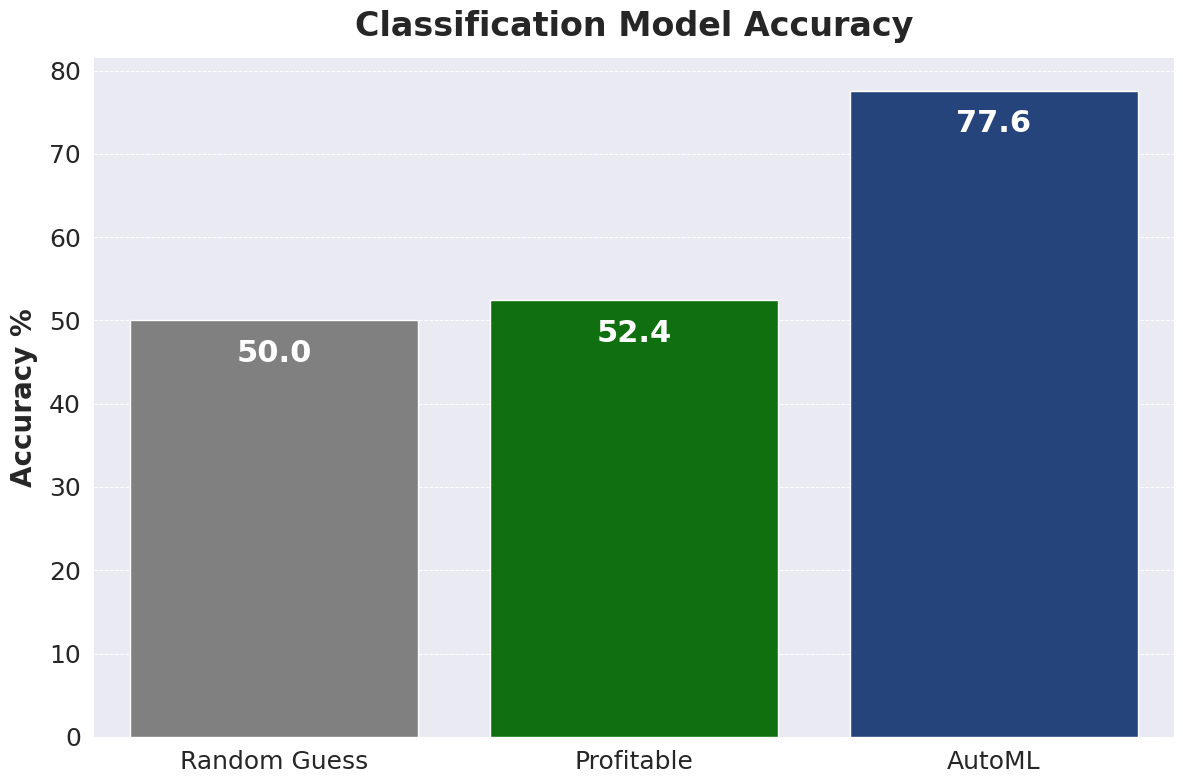

In [115]:
# Example usage with updated specifications
accuracies = [50.0, 52.4, 77.6]
categories = ["Random Guess", "Profitable", "AutoML"]
colors = ["grey", "green", "#17408B"]

plot_model_accuracy_seaborn(
    accuracies, categories, colors, save=False, image_name="cls_model_accuracy"
)